# Exploratory Data Analysis

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from walmart_sales.constants import PROCESSED_DATA_DIR, PROCESSED_DATA_FILE
from walmart_sales.utils import get_week_diff

In [2]:
df_full = pd.read_csv(Path("..", PROCESSED_DATA_DIR, PROCESSED_DATA_FILE), parse_dates=["Date"])

## Data description

- Target column: Weekly_Sales.
- Granularity is defined by Store-Dept-Date combination.
- Frequency of observations is weekly, however ~18% Store-Dept combinations have gaps. These combinations are responsible for ~9% of overall data.
  - On average, weekly sales are 10 times smaller and the meadian is 100 times smaller in departments with gaps.
  - My hypothesis is that the gaps exist not because of some bug in data collection. Rather they just mean that there were 0 sales in that department during that week (though in some cases zeroes are explicitly in the data). However, this needs additional verification, as well as the question of whether we need to forecast for such departments. It may be the case that zeroes are known in advance in some cases, for example because the department was temporarily closed.
  - I'll drop the departments with gaps for this example to save time. Otherwise, I'd talk to business about the reasons of these gaps and ways to handle them. At least some periods without gaps could be used to enhance train and test data.
- The dataset starts on 2010-02-05 and ends on 2012-10-26, so 143 weeks are available. This is also true for 80% of individual departments, and for 97.5% of departments without gaps.
- A week is represented by a corresponding Friday date.

In [3]:
df_full.Date.min(), df_full.Date.max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [4]:
df_full.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [5]:
# granularity check
df_full.groupby(["Store", "Dept", "Date"], as_index=False)["Weekly_Sales"].count().sort_values("Weekly_Sales", ascending=False).head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2010-02-05,1
281042,29,30,2010-09-17,1
281052,29,30,2010-11-26,1
281051,29,30,2010-11-19,1
281050,29,30,2010-11-12,1


In [6]:
# check for gaps in data
df_counts = df_full.groupby(["Store", "Dept"], as_index=False)["Date"].agg(["min", "max", "count"])
df_counts["expected_count"] = df_counts.apply(lambda x: get_week_diff(x["min"], x["max"]) + 1, axis=1)
df_counts

,Store,Dept,min,max,count,expected_count
0,1,1,2010-02-05,2012-10-26,143,143
1,1,2,2010-02-05,2012-10-26,143,143
2,1,3,2010-02-05,2012-10-26,143,143
3,1,4,2010-02-05,2012-10-26,143,143
4,1,5,2010-02-05,2012-10-26,143,143
...,...,...,...,...,...,...
3326,45,94,2010-02-12,2012-10-26,134,142
3327,45,95,2010-02-05,2012-10-26,143,143
3328,45,96,2012-03-16,2012-09-14,2,27
3329,45,97,2010-02-05,2012-10-26,143,143


In [7]:
df_with_gaps = df_counts[df_counts["expected_count"] > df_counts["count"]]
df_with_gaps

,Store,Dept,min,max,count,expected_count
16,1,18,2010-02-05,2012-10-26,113,143
41,1,45,2010-02-05,2012-10-26,71,143
43,1,47,2010-02-05,2012-09-28,22,139
44,1,48,2010-02-05,2012-10-26,125,143
46,1,51,2010-02-05,2010-10-15,33,37
...,...,...,...,...,...,...
3314,45,78,2010-02-12,2011-07-15,8,75
3316,45,80,2010-02-05,2012-10-26,130,143
3326,45,94,2010-02-12,2012-10-26,134,142
3328,45,96,2012-03-16,2012-09-14,2,27


In [8]:
print(f"Share of Store-Depts with gaps: {len(df_with_gaps) / len(df_counts):.3f}")
print(f"Share of dataset coming from series with gaps: {df_with_gaps['count'].sum() / df_counts['count'].sum():.3f}")

Share of Store-Depts with gaps: 0.182
Share of dataset coming from series with gaps: 0.094


<Axes: title={'center': 'Percentage of data missing'}, ylabel='Frequency'>

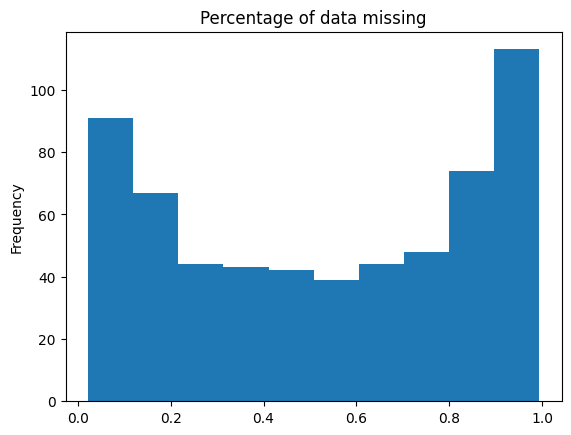

In [9]:
(df_with_gaps["count"] / df_with_gaps["expected_count"]).plot(kind="hist", title="Percentage of data missing")

In [10]:
df_full[(df_full.Store == 45) & (df_full.Dept == 78)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
412052,45,78,2010-02-12,12.0,True,B,118221,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992
412121,45,78,2010-02-19,12.0,False,B,118221,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992
412191,45,78,2010-02-26,12.0,False,B,118221,34.89,2.754,NaN,NaN,NaN,NaN,NaN,182.077469,8.992
412462,45,78,2010-03-26,12.0,False,B,118221,54.36,2.854,NaN,NaN,NaN,NaN,NaN,181.971870,8.992
412729,45,78,2010-04-23,12.0,False,B,118221,53.47,2.902,NaN,NaN,NaN,NaN,NaN,181.677256,8.899
412929,45,78,2010-05-14,12.0,False,B,118221,54.26,2.982,NaN,NaN,NaN,NaN,NaN,181.661279,8.899
414059,45,78,2010-09-10,15.0,True,B,118221,70.87,2.699,NaN,NaN,NaN,NaN,NaN,182.598178,8.743
417011,45,78,2011-07-15,1.0,False,B,118221,78.47,3.760,NaN,NaN,NaN,NaN,NaN,186.139981,8.625


In [11]:
df_full[(df_full.Store == 1) & (df_full.Dept == 45)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
41,1,45,2010-02-05,37.44,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
114,1,45,2010-02-12,34.47,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
186,1,45,2010-02-19,22.94,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
259,1,45,2010-02-26,45.41,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
331,1,45,2010-03-05,74.35,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9708,1,45,2012-09-07,10.47,True,A,151315,83.96,3.730,5204.68,35.74,50.94,4120.32,2737.17,222.439015,6.908
9853,1,45,2012-09-21,52.35,False,A,151315,69.87,3.721,6352.30,7.64,4.69,1010.06,6456.71,222.781839,6.908
9924,1,45,2012-09-28,20.94,False,A,151315,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,222.981658,6.908
10069,1,45,2012-10-12,10.47,False,A,151315,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,223.381296,6.573


In [12]:
df_with_gaps.merge(df_full).Weekly_Sales.mean(), df_with_gaps.merge(df_full).Weekly_Sales.median()

(1353.189746286815, 77.61500000000001)

In [13]:
df_full.Weekly_Sales.mean(), df_full.Weekly_Sales.median()

(15981.25812346704, 7612.03)

In [14]:
df_full[df_full.Weekly_Sales == 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
4132,1,47,2011-03-11,0.0,False,A,151315,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742
5691,1,47,2011-08-12,0.0,False,A,151315,90.76,3.638,NaN,NaN,NaN,NaN,NaN,215.605788,7.962
5762,1,47,2011-08-19,0.0,False,A,151315,89.94,3.554,NaN,NaN,NaN,NaN,NaN,215.669311,7.962
10732,2,60,2010-03-19,0.0,False,A,202307,54.52,2.720,NaN,NaN,NaN,NaN,NaN,210.873332,8.324
18449,2,47,2012-04-13,0.0,False,A,202307,68.08,3.891,8994.04,6573.08,20.21,4162.20,1966.38,221.148403,6.891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402827,43,85,2012-01-13,0.0,False,C,41062,43.68,3.261,894.04,209.71,32.36,NaN,1191.88,211.411571,9.653
407180,44,27,2011-01-14,0.0,False,C,39910,20.60,2.903,NaN,NaN,NaN,NaN,NaN,127.300935,7.224
414388,45,54,2010-10-15,0.0,False,B,118221,58.61,2.868,NaN,NaN,NaN,NaN,NaN,182.810620,8.724
415525,45,47,2011-02-11,0.0,True,B,118221,30.30,3.239,NaN,NaN,NaN,NaN,NaN,183.701613,8.549


In [15]:
len(df_counts[df_counts["count"] == 143]) / len(df_counts)

0.7985589912939057

In [16]:
len(df_counts[df_counts["count"] == 143]) / sum(df_counts["expected_count"] == df_counts["count"])

0.9757887013939839

## Features

In [17]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

### Store

- Different stores have different average weekly sales. Some target encoding could be possibly used when modeling.

In [18]:
df_full.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

<Axes: xlabel='Store', ylabel='Data points'>

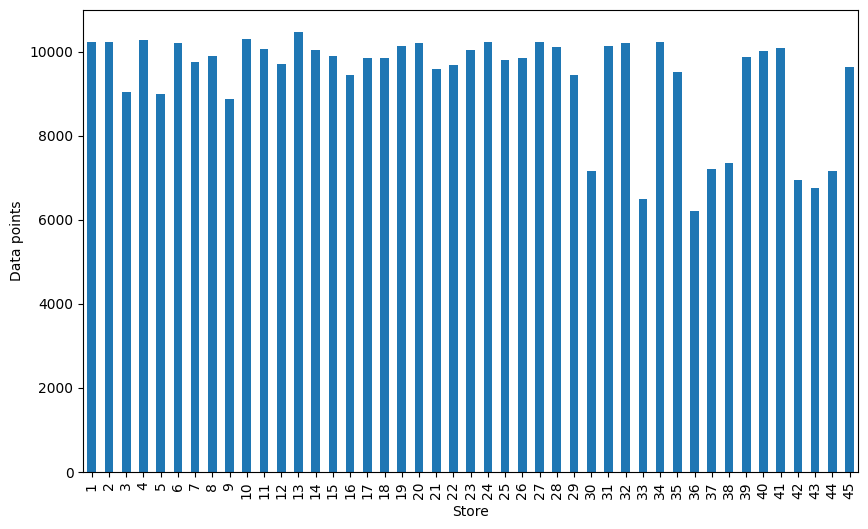

In [19]:
plt.figure(figsize=(10,6))
plt.ylabel("Data points")
df_full.groupby("Store")["Weekly_Sales"].count().plot.bar()

<Axes: xlabel='Store', ylabel='Mean weekly sales'>

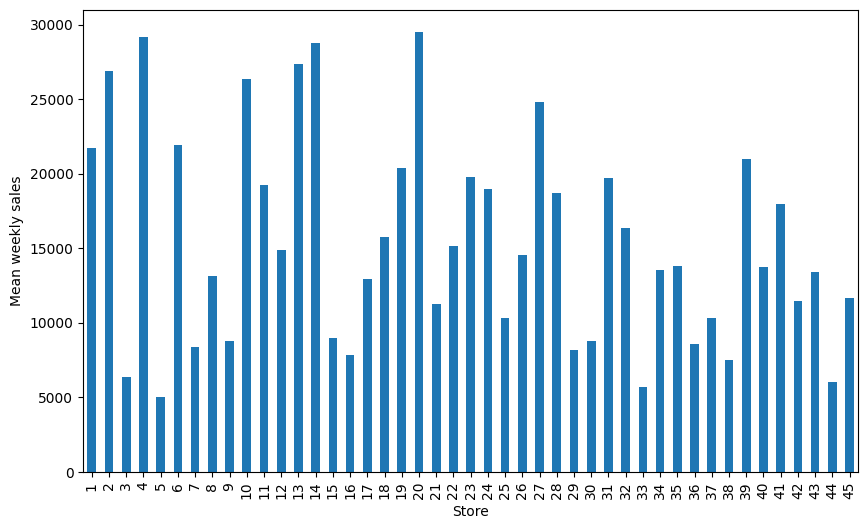

In [20]:
plt.figure(figsize=(10,6))
plt.ylabel("Mean weekly sales")
df_full.groupby("Store")["Weekly_Sales"].mean().plot.bar()

### Dept

- Each store has roughly 60-80 departments represented by integers from 1 to 99.
- The distribution of average weekly sales looks similar for the whole dataset and individual stores, which means that the same department number has the same meaning for different stores.

In [21]:
df_full.Dept.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92,
       93, 94, 95, 97, 98, 78, 96, 99, 77, 39, 50, 43, 65])

In [22]:
df_full.Dept.nunique()

81

<Axes: xlabel='Store', ylabel='Number of departments'>

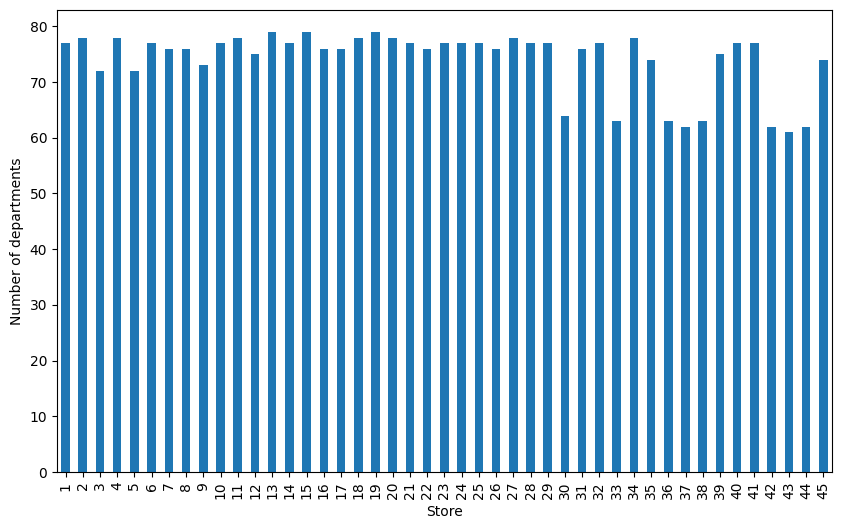

In [23]:
plt.figure(figsize=(10,6))
plt.ylabel("Number of departments")
df_full.groupby("Store")["Dept"].nunique().plot.bar()

<Axes: title={'center': 'Full dataset'}, xlabel='Dept', ylabel='Mean weekly sales'>

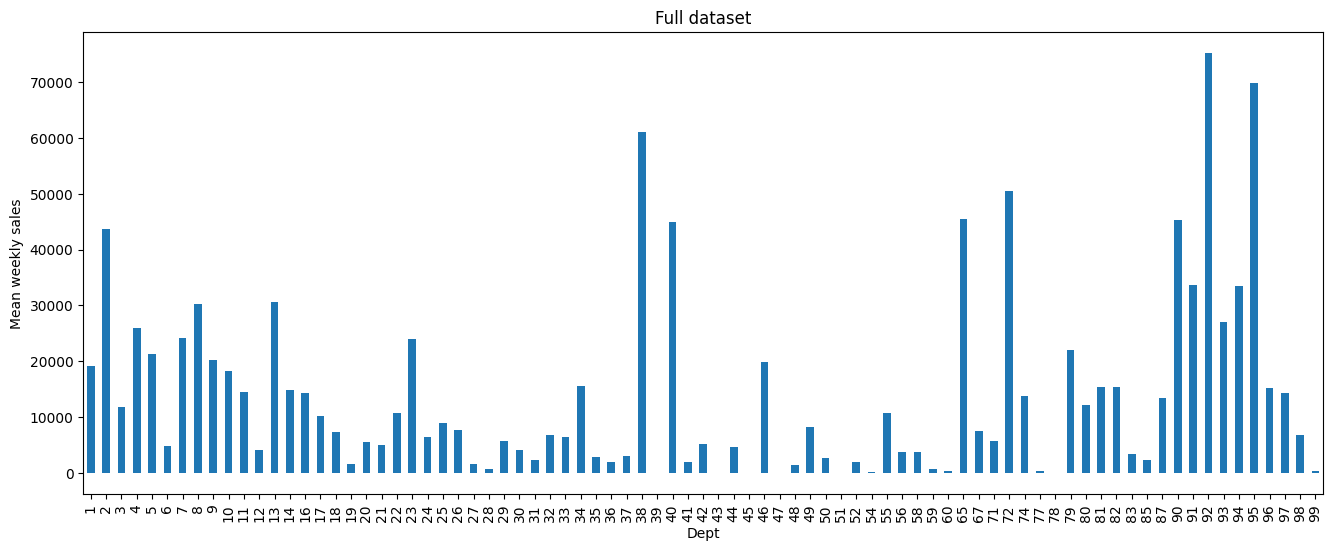

In [24]:
plt.figure(figsize=(16,6))
plt.ylabel("Mean weekly sales")
plt.title("Full dataset")
df_full.sort_values("Dept").groupby("Dept")["Weekly_Sales"].mean().plot.bar()

<Axes: title={'center': 'Store 1'}, xlabel='Dept', ylabel='Mean weekly sales'>

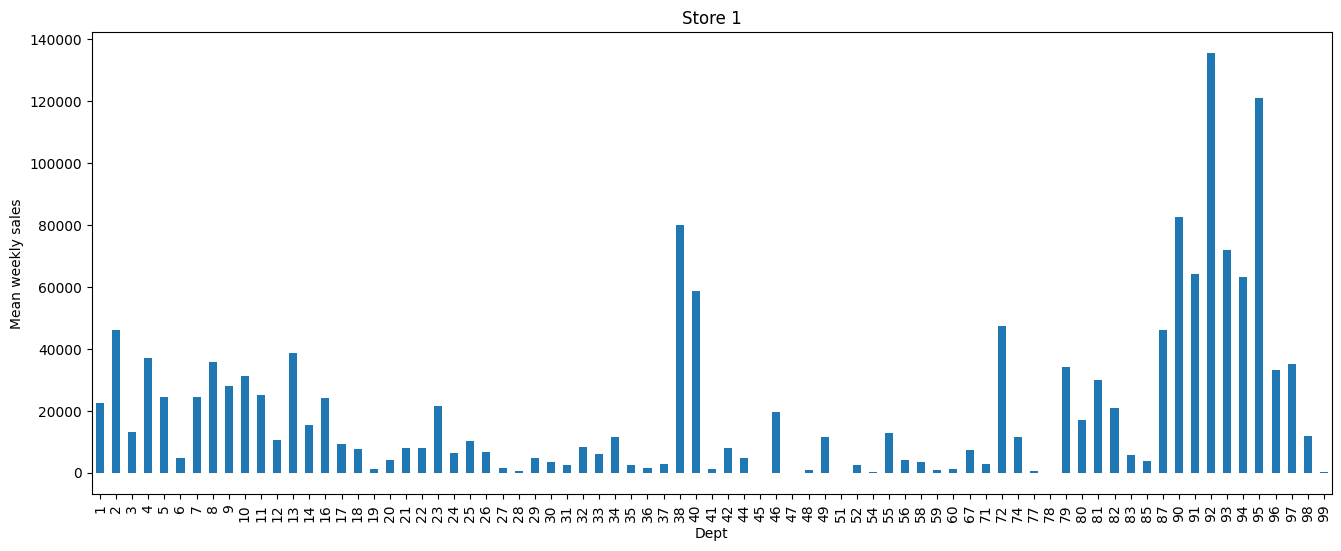

In [25]:
plt.figure(figsize=(16,6))
plt.ylabel("Mean weekly sales")
plt.title("Store 1")
df_full[df_full.Store == 1].sort_values("Dept").groupby("Dept")["Weekly_Sales"].mean().plot.bar()

<Axes: title={'center': 'Store 2'}, xlabel='Dept', ylabel='Mean weekly sales'>

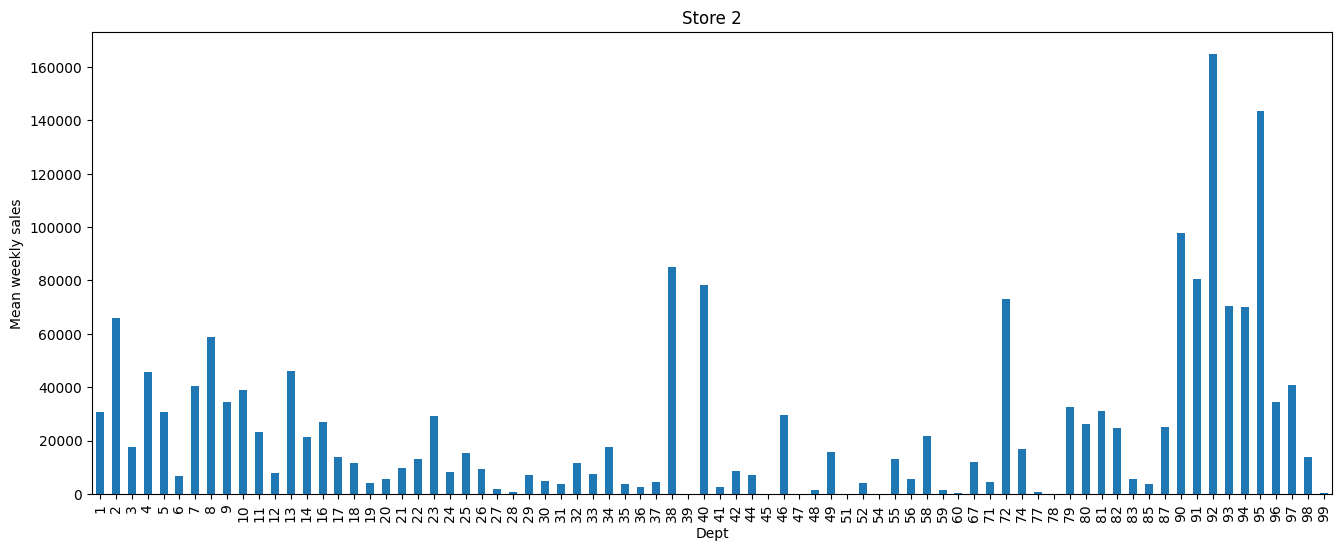

In [26]:
plt.figure(figsize=(16,6))
plt.ylabel("Mean weekly sales")
plt.title("Store 2")
df_full[df_full.Store == 2].sort_values("Dept").groupby("Dept")["Weekly_Sales"].mean().plot.bar()

### Date

- The number of data points is more or less consistent through the whole period.
- There are two 50-60% spikes in weekly sales at the end of each year. 

<Axes: xlabel='Date', ylabel='Data points'>

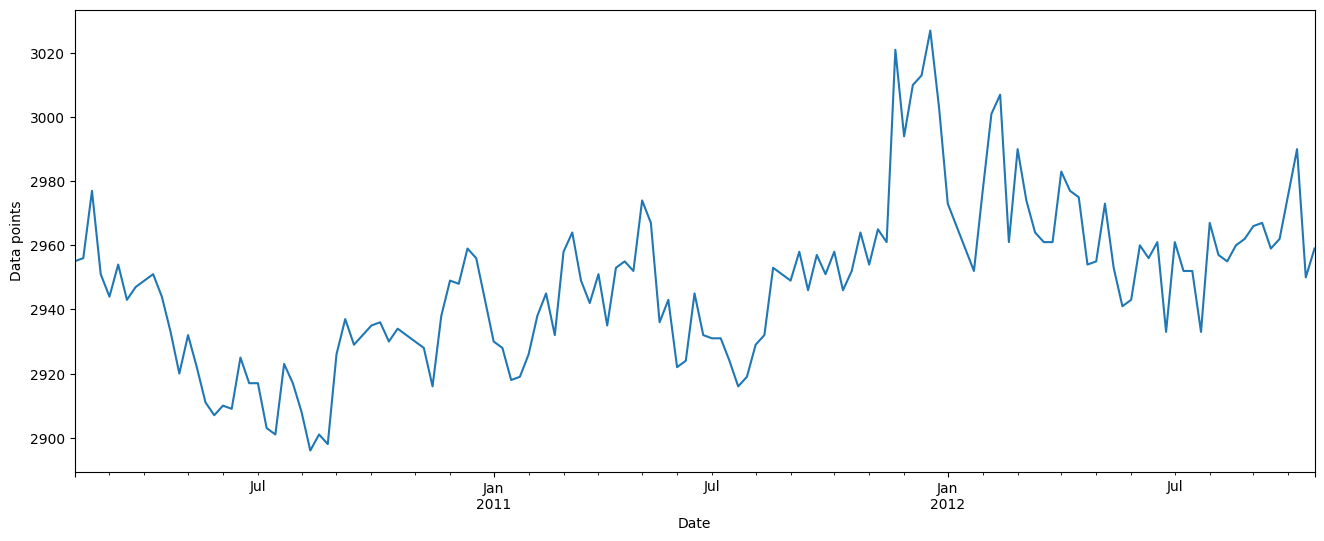

In [27]:
plt.figure(figsize=(16,6))
plt.ylabel("Data points")
df_full.groupby("Date")["Weekly_Sales"].count().plot()

<Axes: xlabel='Date', ylabel='Data points'>

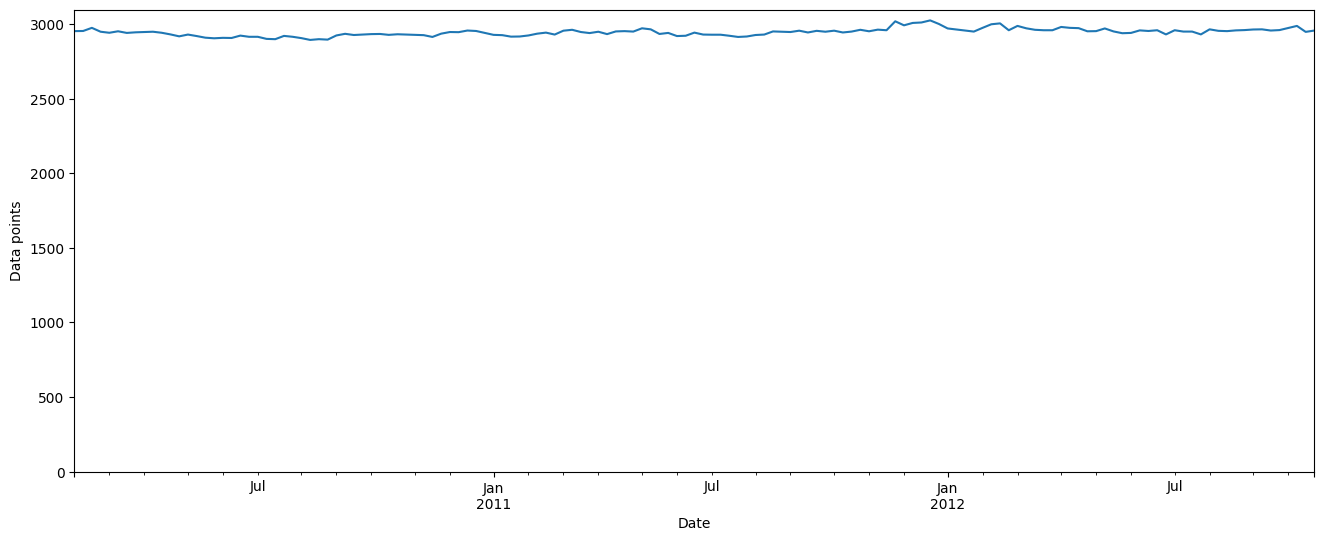

In [28]:
plt.figure(figsize=(16,6))
plt.ylabel("Data points")
plt.ylim(0, 3100)
df_full.groupby("Date")["Weekly_Sales"].count().plot()

<Axes: xlabel='Date', ylabel='Total weekly sales'>

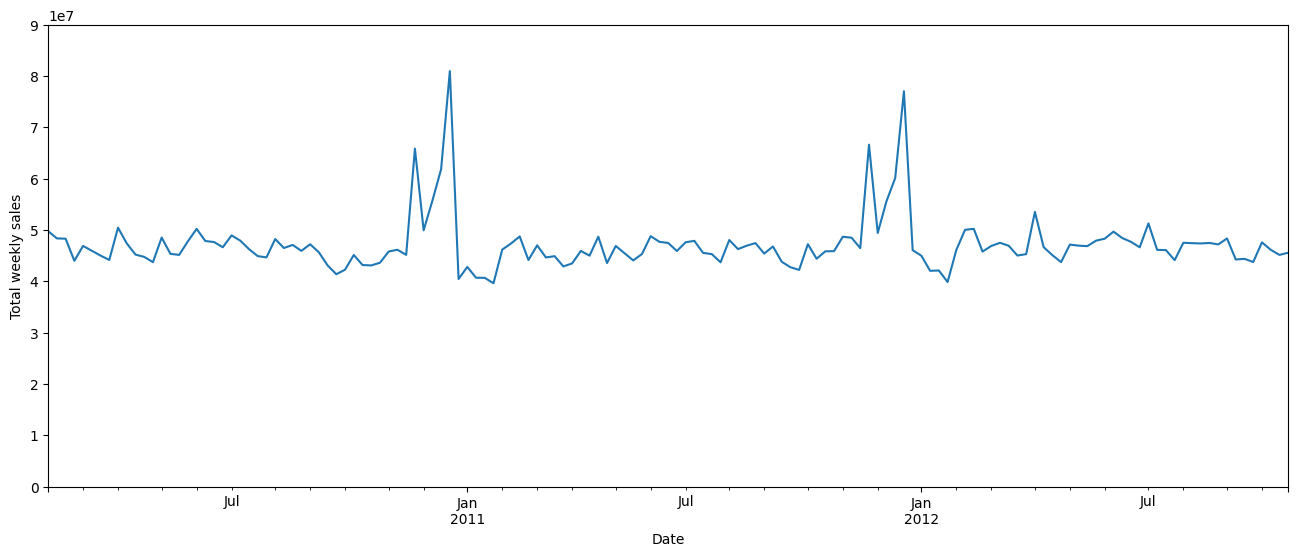

In [29]:
plt.figure(figsize=(16,6))
plt.ylim(0, 9e7)
plt.ylabel("Total weekly sales")
df_full.groupby("Date")["Weekly_Sales"].sum().plot()

### Weekly_Sales

- Usually positive, may be negative or zero(0.3% of cases)
- The distribution looks exponential, some kind of target transformation may be useful, e.g., Box-Cox transformation

In [30]:
df_full.Weekly_Sales.describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

In [31]:
sum(df_full.Weekly_Sales <= 0) / len(df_full)

0.003221291837654482

<Axes: >

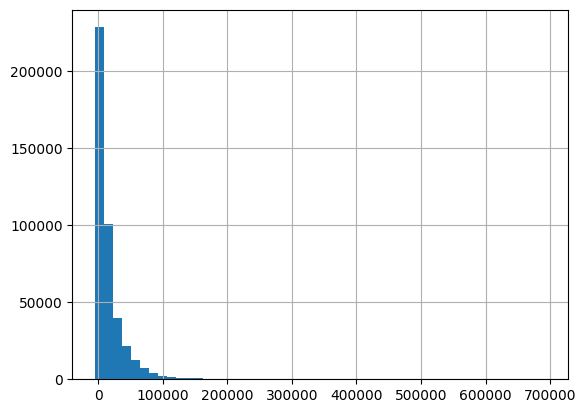

In [32]:
df_full.Weekly_Sales.hist(bins=50)

<Axes: >

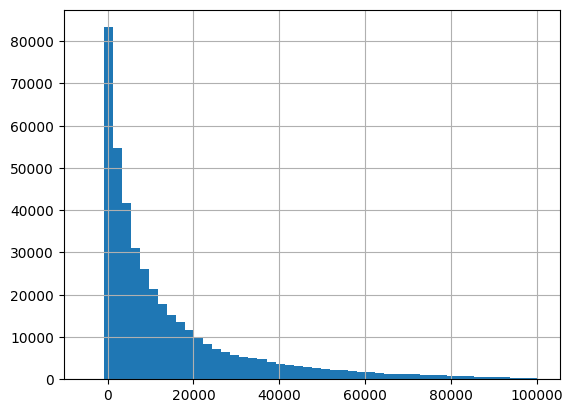

In [33]:
df_full.Weekly_Sales[df_full.Weekly_Sales < 100000].hist(bins=50)

<Axes: >

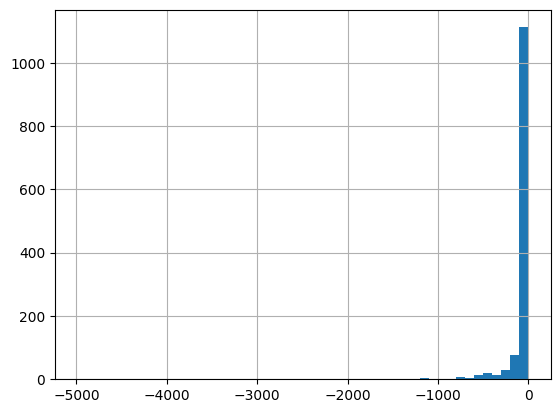

In [34]:
df_full.Weekly_Sales[df_full.Weekly_Sales < 0].hist(bins=50)

<Axes: >

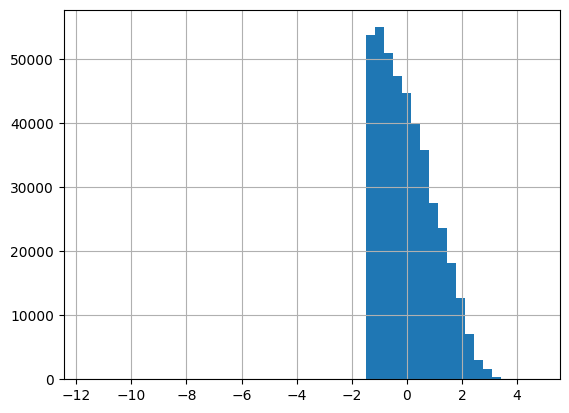

In [35]:
# possible transformation for target
x = np.log(df_full.Weekly_Sales - df_full.Weekly_Sales.min() + 1)
((x - x.mean()) / x.std()).hist(bins=50)

<Axes: >

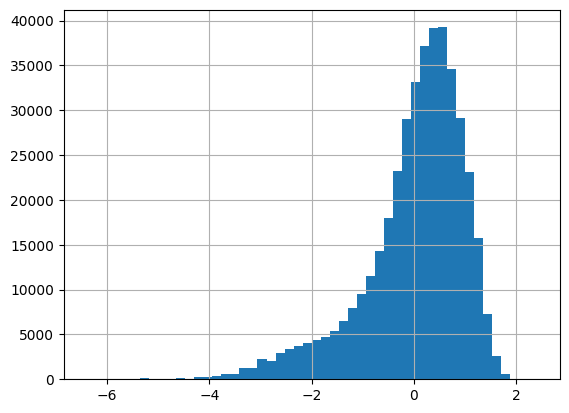

In [36]:
# possible transformation for target, excluding non-positives
x = np.log(df_full.Weekly_Sales[df_full.Weekly_Sales >= 1e-3])
((x - x.mean()) / x.std()).hist(bins=50)

### IsHoliday

- Valentine's Day (or Super Bowl?), Labor Day, Thanksgiving + Black Friday, Christmas
- Average sales are slightly higher on holidays

In [37]:
df_full.IsHoliday.value_counts()

IsHoliday
False    391909
True      29661
Name: count, dtype: int64

In [38]:
sorted(df_full[df_full.IsHoliday].Date.unique())

[Timestamp('2010-02-12 00:00:00'),
 Timestamp('2010-09-10 00:00:00'),
 Timestamp('2010-11-26 00:00:00'),
 Timestamp('2010-12-31 00:00:00'),
 Timestamp('2011-02-11 00:00:00'),
 Timestamp('2011-09-09 00:00:00'),
 Timestamp('2011-11-25 00:00:00'),
 Timestamp('2011-12-30 00:00:00'),
 Timestamp('2012-02-10 00:00:00'),
 Timestamp('2012-09-07 00:00:00')]

<Axes: xlabel='IsHoliday', ylabel='Mean weekly sales'>

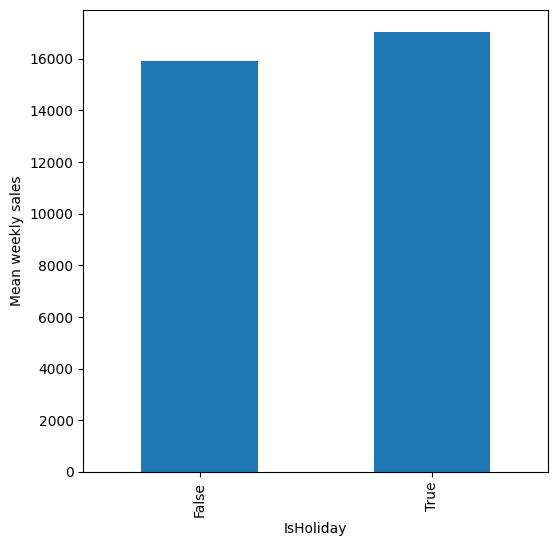

In [39]:
plt.figure(figsize=(6,6))
plt.ylabel("Mean weekly sales")
df_full.groupby("IsHoliday")["Weekly_Sales"].mean().plot.bar()

### Type and Size

- Both size and type are characteristics of a store that don't change over time.
- There are three types: A, B, and C. They correlate with size and weekly sales, but type is still not a proper quantization of size as seen from the table and plot below.

In [40]:
(df_full.groupby("Store")["Type"].nunique() == 1).all()

True

In [41]:
(df_full.groupby("Store")["Size"].nunique() == 1).all()

True

<Axes: xlabel='Type', ylabel='Mean weekly sales'>

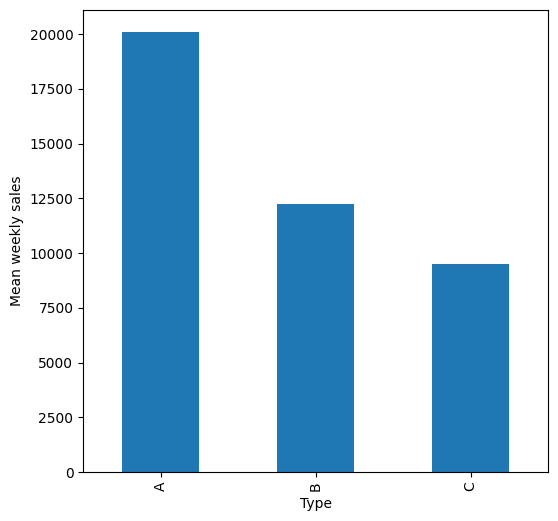

In [42]:
plt.figure(figsize=(6,6))
plt.ylabel("Mean weekly sales")
df_full.groupby("Type")["Weekly_Sales"].mean().plot.bar()

<Axes: xlabel='Type', ylabel='Mean store size'>

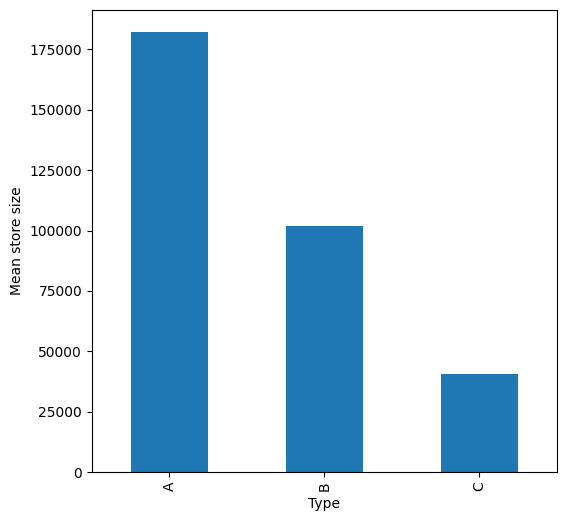

In [43]:
plt.figure(figsize=(6,6))
plt.ylabel("Mean store size")
df_full.groupby("Type")["Size"].mean().plot.bar()

In [44]:
df_full.groupby("Type")["Size"].agg(["min", "max"])

,min,max
Type,,
A,39690,219622
B,34875,140167
C,39690,42988


<Axes: xlabel='Size', ylabel='Weekly_Sales'>

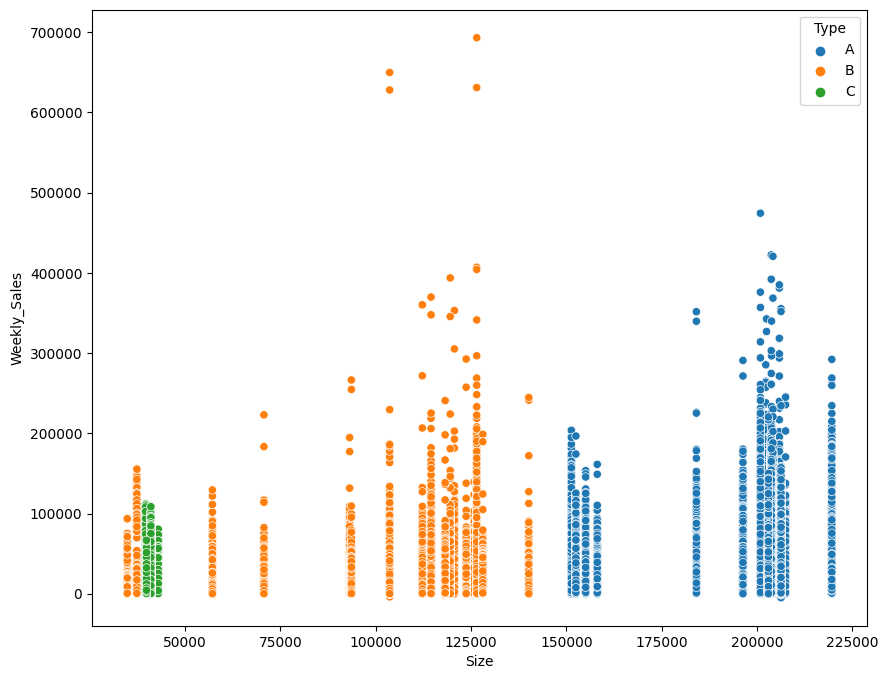

In [45]:
plt.figure(figsize=(10,8))
sns.scatterplot(df_full, x="Size", y="Weekly_Sales", hue="Type")

<Axes: >

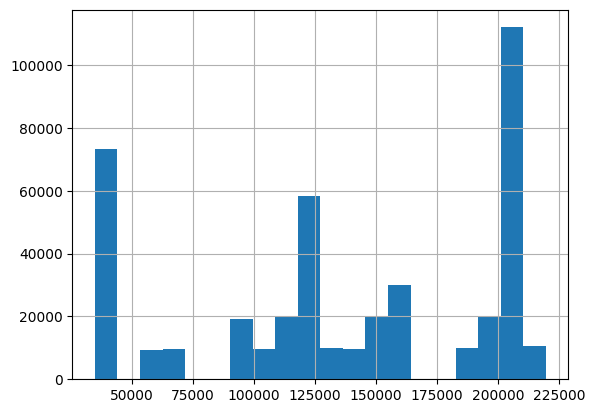

In [46]:
df_full["Size"].hist(bins=20)

### Temperature

- Temperature is in range between -2 and 100, most probably all in Fahrenheit.
- The average temperature differs by store.
- Not much visible association between temperature and weekly sales.

In [47]:
df_full.Temperature.describe()

count    421570.000000
mean         60.090059
std          18.447931
min          -2.060000
25%          46.680000
50%          62.090000
75%          74.280000
max         100.140000
Name: Temperature, dtype: float64

<Axes: >

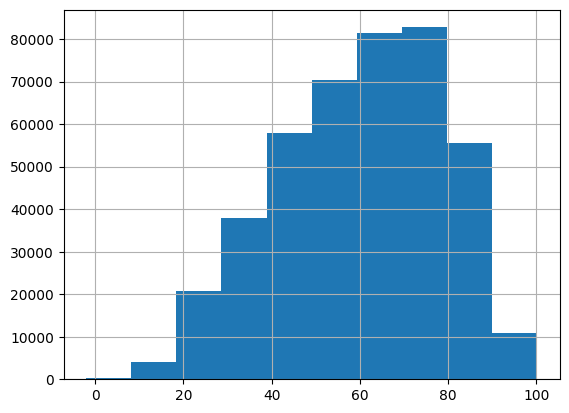

In [48]:
df_full.Temperature.hist()

<Axes: xlabel='Store', ylabel='Average temperature'>

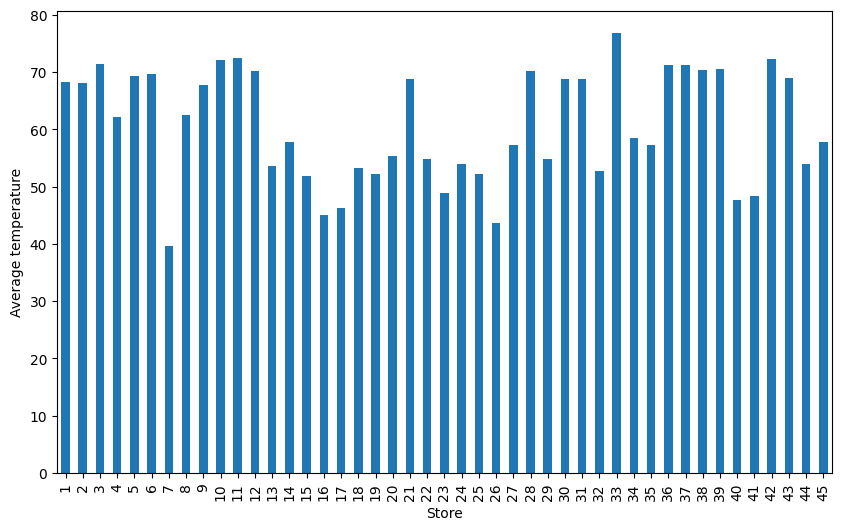

In [49]:
plt.figure(figsize=(10,6))
plt.ylabel("Average temperature")
df_full.groupby("Store").Temperature.mean().plot.bar()

<Axes: xlabel='Temperature', ylabel='Average weekly sales'>

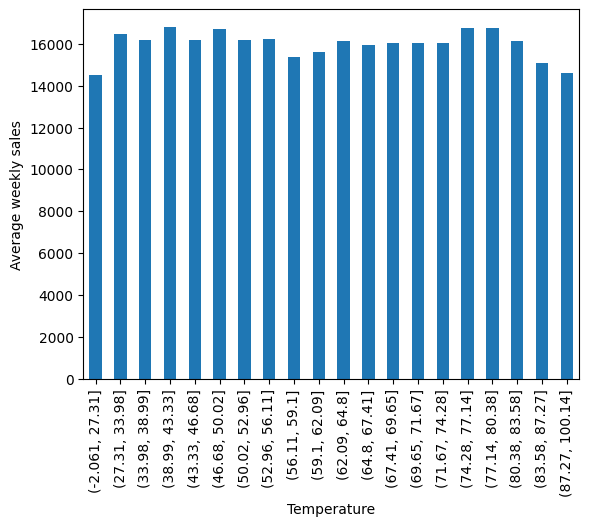

In [50]:
plt.ylabel("Average weekly sales")
df_full.groupby(pd.qcut(df_full.Temperature, 20))["Weekly_Sales"].mean().plot.bar()

### Fuel_Price

- Differs over time, but averages are close for all stores.
- Grows over time. Potential data drift.
- Not much visible association between fuel price and weekly sales.

In [51]:
df_full.Fuel_Price.describe()

count    421570.000000
mean          3.361027
std           0.458515
min           2.472000
25%           2.933000
50%           3.452000
75%           3.738000
max           4.468000
Name: Fuel_Price, dtype: float64

<Axes: >

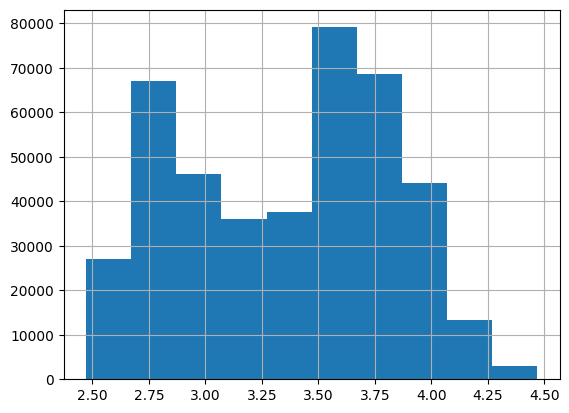

In [52]:
df_full.Fuel_Price.hist()

<Axes: xlabel='Date', ylabel='Fuel price'>

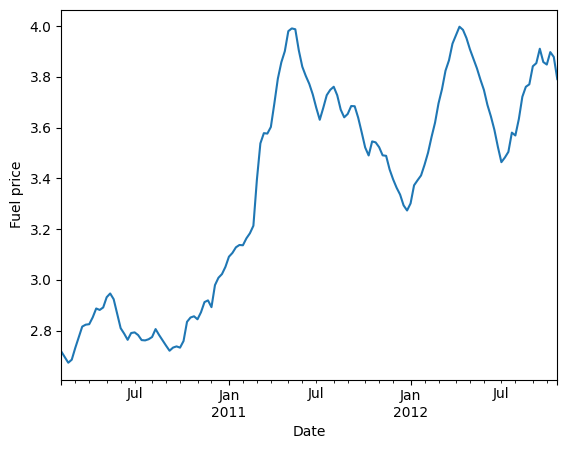

In [53]:
plt.ylabel("Fuel price")
df_full.groupby("Date")["Fuel_Price"].mean().plot()

<Axes: xlabel='Store', ylabel='Average fuel price'>

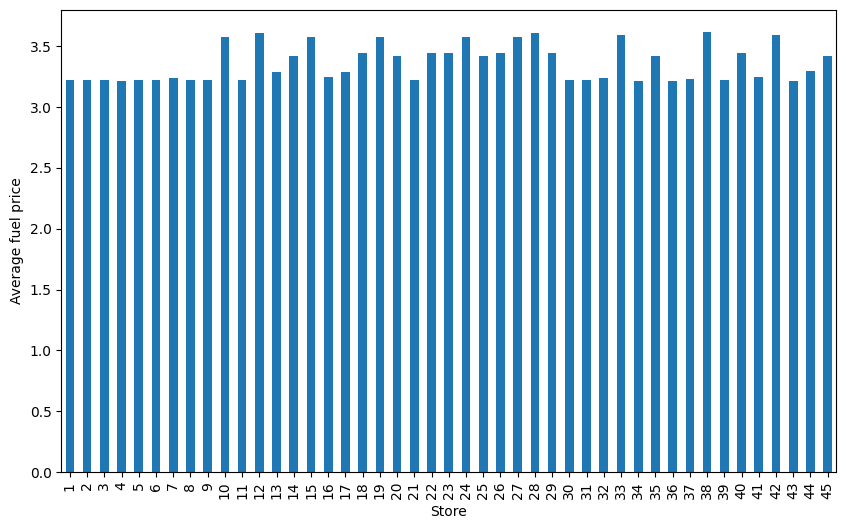

In [54]:
plt.figure(figsize=(10,6))
plt.ylabel("Average fuel price")
df_full.groupby("Store").Fuel_Price.mean().plot.bar()

<Axes: xlabel='Fuel_Price', ylabel='Average weekly sales'>

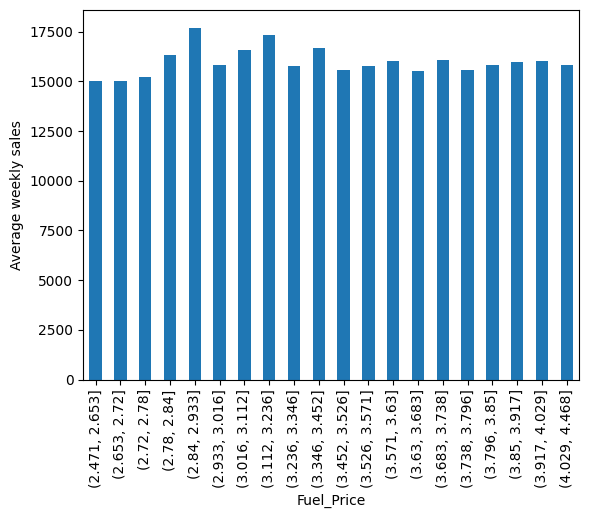

In [55]:
plt.ylabel("Average weekly sales")
df_full.groupby(pd.qcut(df_full.Fuel_Price, 20))["Weekly_Sales"].mean().plot.bar()

### CPI

- Consumer price index.
- May be different for different store in the same week.
- Grows over time. Potential data drift.
- Not much association with weekly sales.

In [56]:
df_full.CPI.describe()

count    421570.000000
mean        171.201947
std          39.159276
min         126.064000
25%         132.022667
50%         182.318780
75%         212.416993
max         227.232807
Name: CPI, dtype: float64

<Axes: >

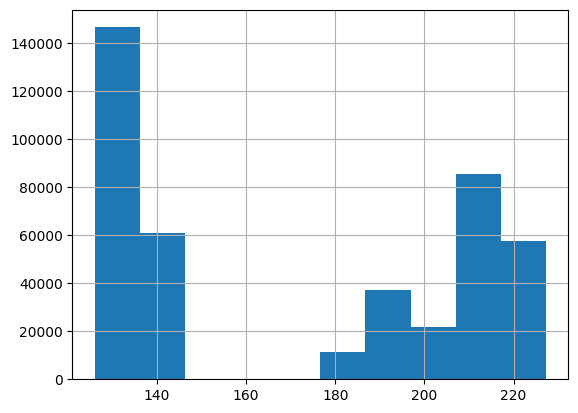

In [57]:
df_full.CPI.hist()

In [58]:
df_full.groupby("Date")["CPI"].nunique()

Date
2010-02-05    15
2010-02-12    15
2010-02-19    15
2010-02-26    15
2010-03-05    15
              ..
2012-09-28    15
2012-10-05    15
2012-10-12    15
2012-10-19    15
2012-10-26    15
Name: CPI, Length: 143, dtype: int64

<Axes: xlabel='Date', ylabel='CPI'>

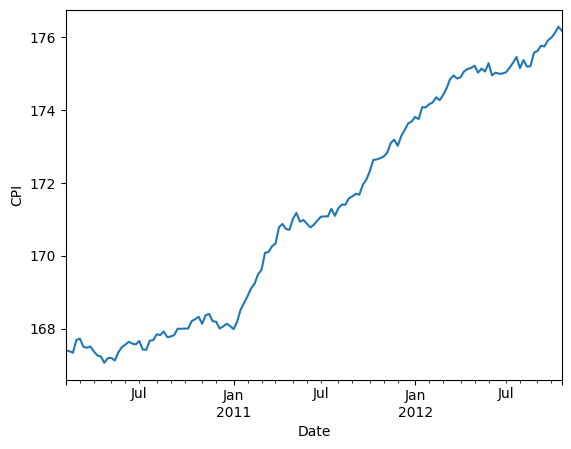

In [59]:
plt.ylabel("CPI")
df_full.groupby("Date")["CPI"].mean().plot()

<Axes: xlabel='CPI', ylabel='Average weekly sales'>

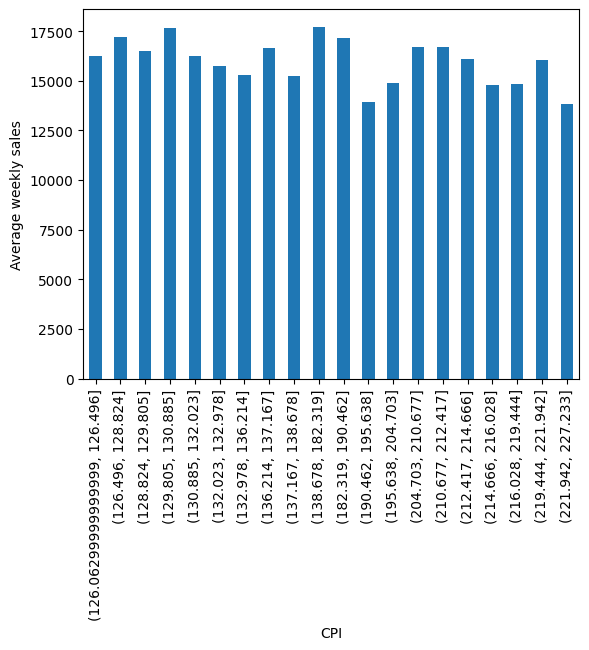

In [60]:
plt.ylabel("Average weekly sales")
df_full.groupby(pd.qcut(df_full.CPI, 20))["Weekly_Sales"].mean().plot.bar()

### Unemployment

- May be different for different store in the same week.
- Decreases over time. Potential data drift.
- Not much association with weekly sales, however some variability is visible (may be due to confounders).

In [61]:
df_full.Unemployment.describe()

count    421570.000000
mean          7.960289
std           1.863296
min           3.879000
25%           6.891000
50%           7.866000
75%           8.572000
max          14.313000
Name: Unemployment, dtype: float64

<Axes: >

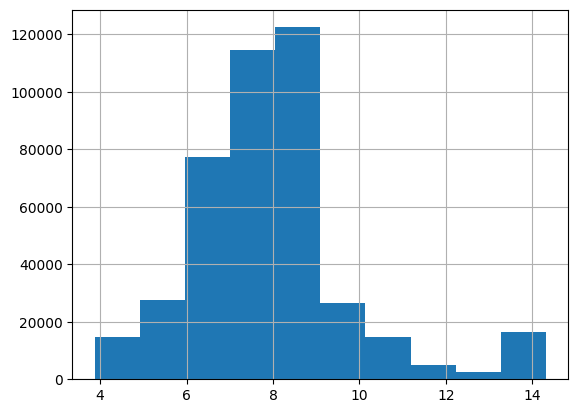

In [62]:
df_full.Unemployment.hist()

In [63]:
df_full.groupby("Date")["Unemployment"].nunique()

Date
2010-02-05    30
2010-02-12    30
2010-02-19    30
2010-02-26    30
2010-03-05    30
              ..
2012-09-28    30
2012-10-05    30
2012-10-12    30
2012-10-19    30
2012-10-26    30
Name: Unemployment, Length: 143, dtype: int64

<Axes: xlabel='Date', ylabel='Unemployment'>

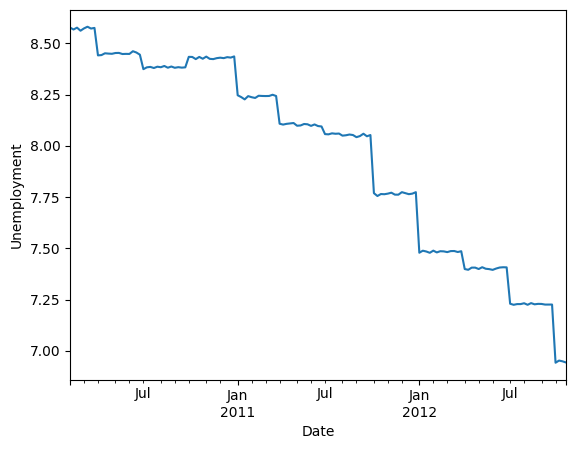

In [64]:
plt.ylabel("Unemployment")
df_full.groupby("Date")["Unemployment"].mean().plot()

<Axes: xlabel='Unemployment', ylabel='Average weekly sales'>

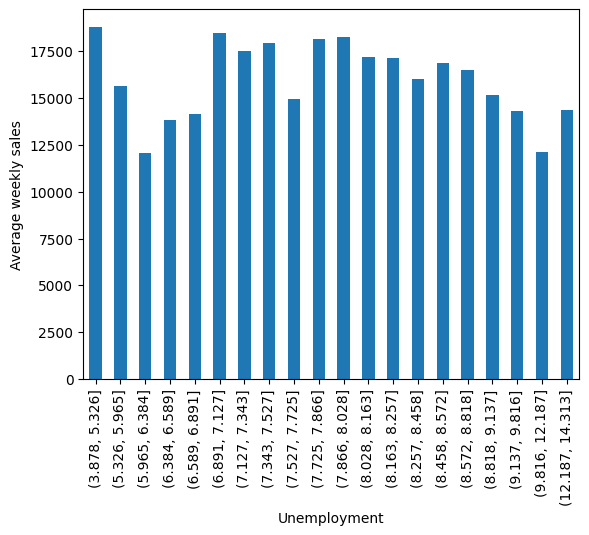

In [65]:
plt.ylabel("Average weekly sales")
df_full.groupby(pd.qcut(df_full.Unemployment, 20))["Weekly_Sales"].mean().plot.bar()

### MarkDown

- Data related to promotional markdowns that Walmart is running.
- 60-70% NaNs.

In [66]:
md_features = [f"MarkDown{i}" for i in range(1, 6)]

In [67]:
df_full[md_features].describe()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
count,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000
mean,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079
std,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455
min,0.270000,-265.760000,-29.100000,0.220000,135.160000
25%,2240.270000,41.600000,5.080000,504.220000,1878.440000
50%,5347.450000,192.000000,24.600000,1481.310000,3359.450000
75%,9210.900000,1926.940000,103.990000,3595.040000,5563.800000
max,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000


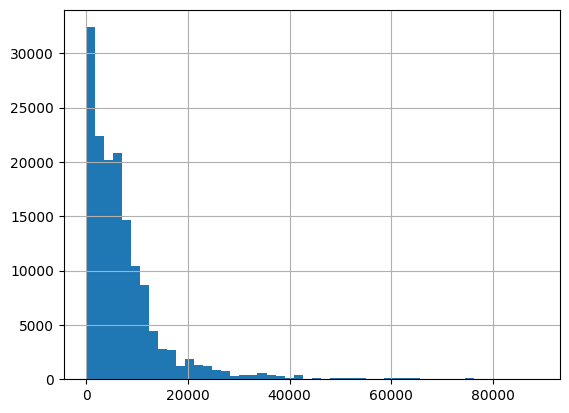

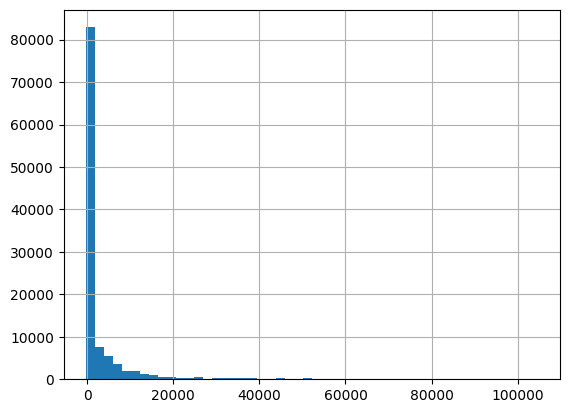

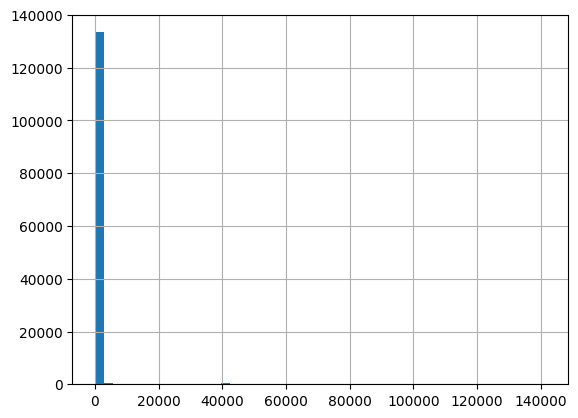

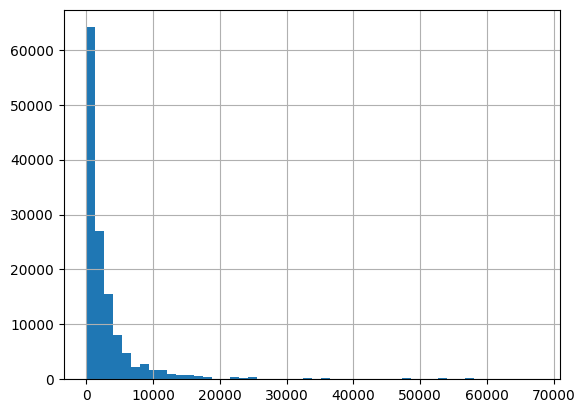

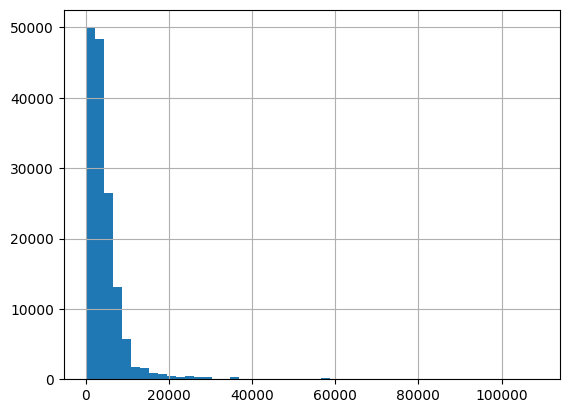

In [68]:
for feature in md_features:
    df_full[feature].hist(bins=50)
    plt.show()

<Axes: >

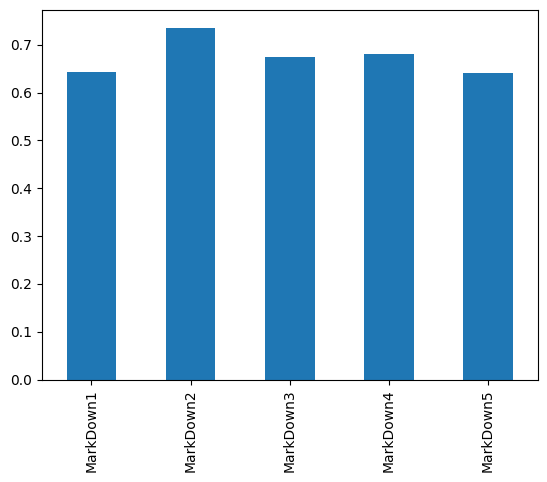

In [69]:
df_full[md_features].isna().sum().div(len(df_full)).plot.bar()

## Sample visualizations

- Departments with same department number have similar patterns
- Visible yearly seasonality

In [70]:
def visualize_sales(store: int, dept: int) -> None:
    df_full.query(f"Store == {store} and Dept == {dept}").set_index("Date")[
        "Weekly_Sales"
    ].plot(ylabel="Weekly Sales", title=f"Store {store}\nDepartment {dept}")

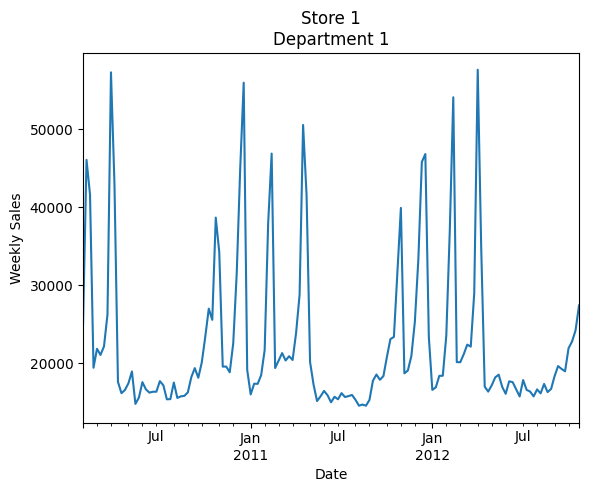

In [71]:
visualize_sales(1, 1)

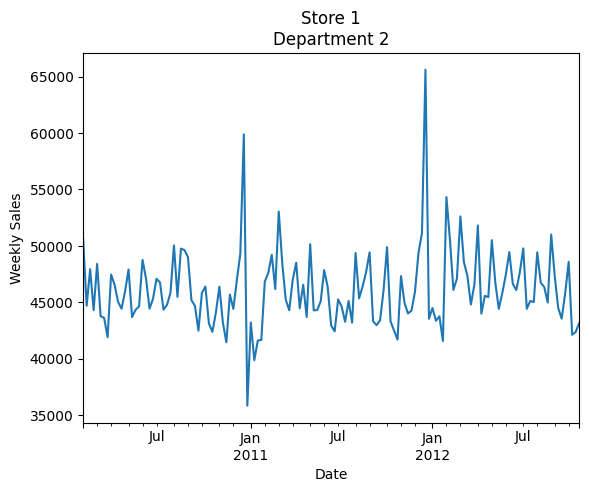

In [72]:
visualize_sales(1, 2)

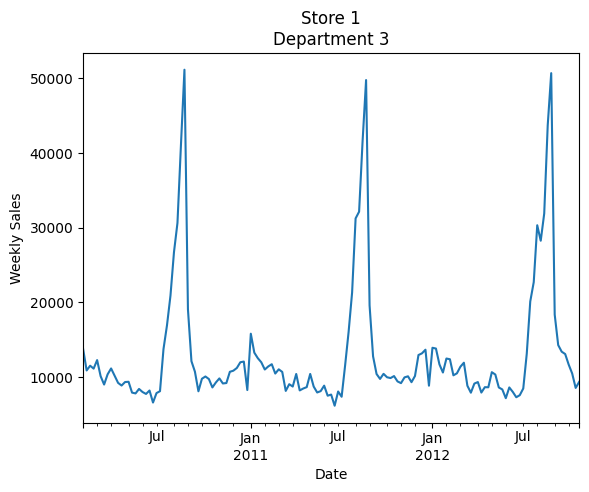

In [73]:
visualize_sales(1, 3)

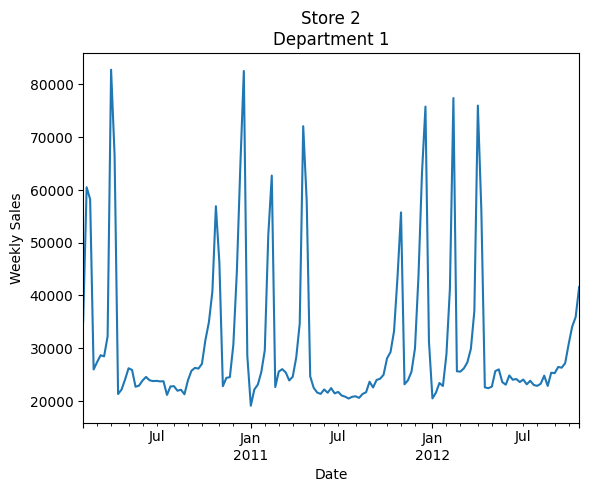

In [74]:
visualize_sales(2, 1)

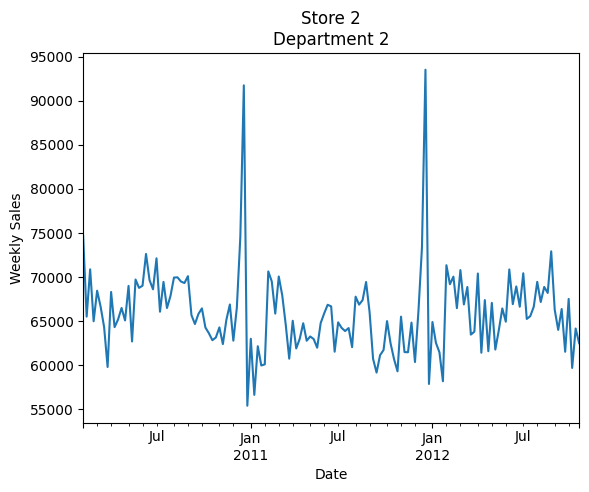

In [75]:
visualize_sales(2, 2)

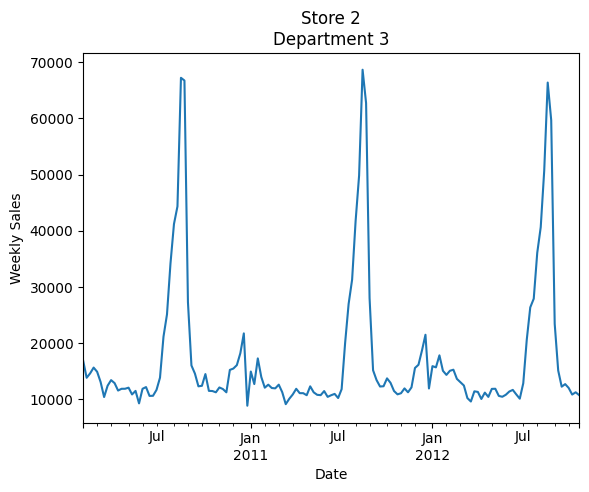

In [76]:
visualize_sales(2, 3)